Here, I develope the LSTM

In [1]:
import sys
sys.path.append("../mypkg")
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from easydict import EasyDict as edict
from tqdm import trange, tqdm
import time

plt.style.use(FIG_ROOT/"base.mplstyle")
%matplotlib inline

In [3]:
import importlib
import models.lstm
importlib.reload(models.lstm)

<module 'models.lstm' from '/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/models/lstm.py'>

In [4]:
from utils.reparam import theta2raw_torch, raw2theta_torch, raw2theta_np
from spectrome import Brain
from sgm.sgm import SGM
from utils.misc import save_pkl, save_pkl_dict2folder, load_pkl, load_pkl_folder2dict, delta_time
from models.lstm import LSTM_SGM
from utils.standardize import std_mat, std_vec

In [5]:
# pkgs for pytorch ( Mar 27, 2023) 
import torch
import torch.nn as nn
from torch.functional import F
from torch.optim.lr_scheduler import ExponentialLR

torch.set_default_dtype(torch.float64)
if torch.cuda.is_available():
    torch.cuda.set_device(2)
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)
    torch.backends.cudnn.benchmark = True
else:
    torch.set_default_tensor_type(torch.DoubleTensor)

## Data, fn and paras

In [6]:
# Load the Connectome
brain = Brain.Brain()
brain.add_connectome(DATA_ROOT)
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.bi_symmetric_c()
brain.reduce_extreme_dir()

In [7]:
# some constant parameters for this file
paras = edict()

## I reorder them in an alphabetical order and I change tauC to tauG (Mar 27, 2023)
## the orginal order is taue, taui, tauC, speed, alpha, gii, gei
## paras.par_low = np.asarray([0.005,0.005,0.005,5, 0.1,0.001,0.001])
## paras.par_high = np.asarray([0.03, 0.20, 0.03,20,  1,    2,  0.7])
##

# alpha, gei, gii, taue, tauG, taui, speed 
paras.par_low = np.array([0.1, 0.001,0.001, 0.005, 0.005, 0.005, 5])
paras.par_high = np.asarray([1, 0.7, 2, 0.03, 0.03, 0.20, 20])
paras.prior_bds = np.array([paras.par_low, paras.par_high]).T
paras.names = ["alpha", "gei", "gii", "Taue", "TauG", "Taui", "Speed"]

paras.C = brain.reducedConnectome
paras.D = brain.distance_matrix
paras.freqs = np.linspace(2, 45, 40)

In [8]:
# running parameters
# May change

paras_run = edict()

paras_run.n = 1000
# note k can differ from SGM_net
paras_run.k = 1.0 # the parameter for reparameterization in logistic
paras_run.sd = 10 # The std to generate SGM parameters in raw scale (R)

# to generate ARMA TS
from statsmodels.tsa.arima_process import arma_generate_sample

def gen_arma_ts(n, ndim=7):
    """Generate ARMA ndim-vec ts.
    """
    # ARMA(2, 2)
    ys = []
    for ix in range(ndim):
        arparams = np.array([.75, -.25])
        maparams = np.array([.65, .35])
        ar = np.r_[1, -arparams] # add zero-lag and negate
        ma = np.r_[1, maparams] # add zero-lag
        y = arma_generate_sample(ar, ma, n)
        ys.append(y)
    return np.array(ys)

## Train the model

In [9]:
from torch.utils.data import DataLoader, Dataset
_theta2raw = lambda Y: theta2raw_torch(Y, paras.prior_bds, paras_run.k)

In [10]:
simu_sgm_data = load_pkl_folder2dict(RES_ROOT/"simu_sgm_data_conspeed_1000")

Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/simu_sgm_data_conspeed_1000/PSDs.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/simu_sgm_data_conspeed_1000/PSDs_test.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/simu_sgm_data_conspeed_1000/sgm_paramss.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/simu_sgm_data_conspeed_1000/sgm_paramss_test.pkl


In [11]:
trained_model = load_pkl_folder2dict(RES_ROOT/"SGM_net")
sgm_net = trained_model.model

Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net/loss.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net/loss_test.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net/model.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net/optimizer.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net/paras.pkl


In [27]:
# functions to generate training sample (Apr 1, 2023)
def random_choice(n, batchsize=1, len_seg=None):
    """Randomly select the lower and upper bound of the segment
        args:
            n: len of the total time series
    """
    if len_seg is None:
        len_seg = torch.randint(low=10, high=200, size=(1, ))
    up_bd = torch.randint(low=len_seg.item(), high=n, size=(batchsize, ))
    low_bd = up_bd - len_seg
    return low_bd, up_bd


def random_samples_rnn(X, Y, batchsize=1, 
                       bds=None, 
                       is_std=True, 
                       theta2raw_fn=None):
    """Randomly select a sample from the whole segment
        args:
            X: PSD, num x 68 x nfreq
            Y: params, num x 7, in orignal sgm scale
        return:
            X_seqs: len_seq x batchsize x num_fs
            Y_seqs: len_seq x batchsize x 7
            
    """
    if not isinstance(X, torch.Tensor):
        X = torch.tensor(X)
    if is_std:
        X = X/X.std(axis=(1, 2), keepdims=True)
    if not isinstance(Y, torch.Tensor):
        Y = torch.tensor(Y)
    if theta2raw_fn: 
        Y = theta2raw_fn(Y)
    if bds is None:
        low_bds, up_bds = random_choice(len(X), batchsize)
    else:
        low_bds, up_bds = bds

    X = X.flatten(1)
    X_seqs = []
    Y_seqs = []
    for low_bd, up_bd in zip(low_bds, up_bds):
        X_seq = X[low_bd:up_bd, :].unsqueeze(1)
        Y_seq = Y[low_bd:up_bd].unsqueeze(1)
        X_seqs.append(X_seq)
        Y_seqs.append(Y_seq)
    return torch.cat(X_seqs, dim=1), torch.cat(Y_seqs, dim=1)

In [28]:
def weighted_mse_loss(pred, target, ws=None):
    """
    Calculates the weighted mean squared error loss between predicted and target values.

    Args:
        pred (torch.Tensor): predicted values
        target (torch.Tensor): target values
        ws (torch.Tensor, optional): weights for each value. Defaults to None.

    Returns:
        torch.Tensor: weighted mean squared error loss
    """
    if ws is None:
        ws = torch.ones_like(pred[0])
        ws[:, :20] = ws[:, :20]*10
    return torch.mean((pred-target)**2 * ws)

In [9]:
paras_rnn = edict()
paras_rnn.batchsize = 128
paras_rnn.niter = 5000
paras_rnn.loss_out = 10
paras_rnn.clip = 1 # from 
paras_rnn.lr_step = 500

paras_rnn.k = 1
paras_rnn.hidden_dim = 512
paras_rnn.output_dim = 7
paras_rnn.input_dim = 68*40
paras_rnn.is_bidirectional = True 

In [20]:
rnn = LSTM_SGM(input_dim=paras_rnn.input_dim, 
               hidden_dim=paras_rnn.hidden_dim, 
               output_dim=paras_rnn.output_dim, 
               is_bidirectional=paras_rnn.is_bidirectional, 
               prior_bds=torch.tensor(paras.prior_bds), 
               k = paras_rnn.k, 
               dy_mask = [1, 1, 0, 0, 0, 0, 0]
)


LSTM_SGM(
  (lstm): LSTM(2720, 512, bidirectional=True)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (laynorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (fc2): Linear(in_features=256, out_features=7, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [31]:
# training
loss_cur = 0
losses = []
losses_test = []

t0 = time.time()
sgm_net.eval()
for ix in range(paras_rnn.niter):
    X_seq, Y_seq = random_samples_rnn(simu_sgm_data.PSDs,
                                      simu_sgm_data.sgm_paramss, 
                                      batchsize=paras_rnn.batchsize, 
                                      theta2raw_fn=_theta2raw)
    # Zero the gradients
    optimizer.zero_grad()
    
    theta_pred = rnn(X_seq)
    X_pred = sgm_net(theta_pred.flatten(0, 1))
    loss = loss_fn(X_seq.flatten(0, 1).reshape(-1, 68, 40),
                   X_pred)
    
    # Perform backward pass
    loss.backward()
    
    torch.nn.utils.clip_grad_norm_(rnn.parameters(), paras_rnn.clip)
    # Perform optimization
    optimizer.step()
    
    loss_cur = loss_cur + loss.item()
    if ix % paras_rnn.loss_out == (paras_rnn.loss_out-1):
        losses.append(loss_cur/paras_rnn.loss_out)
        print(f"At iter {ix+1}/{paras_rnn.niter}, "
              f"the losses are {loss_cur/paras_rnn.loss_out:.5f} (train). "
              f"The time used is {delta_time(t0):.3f}s. "
             )
        loss_cur = 0
        rnn.train()
        t0 = time.time()
    
    if ix % paras_rnn.lr_step == (paras_rnn.lr_step-1):
        scheduler.step()

At iter 10/5000, the losses are 6.10254 (train). The time used is 28.244s. 
At iter 20/5000, the losses are 2.72114 (train). The time used is 23.521s. 
At iter 30/5000, the losses are 1.74274 (train). The time used is 35.317s. 
At iter 40/5000, the losses are 1.48783 (train). The time used is 39.245s. 
At iter 50/5000, the losses are 1.39764 (train). The time used is 34.908s. 
At iter 60/5000, the losses are 1.33494 (train). The time used is 47.323s. 
At iter 70/5000, the losses are 1.26502 (train). The time used is 26.371s. 
At iter 80/5000, the losses are 1.28912 (train). The time used is 38.269s. 
At iter 90/5000, the losses are 1.29102 (train). The time used is 28.607s. 
At iter 100/5000, the losses are 1.25414 (train). The time used is 42.942s. 
At iter 110/5000, the losses are 1.26921 (train). The time used is 46.536s. 
At iter 120/5000, the losses are 1.30297 (train). The time used is 43.059s. 
At iter 130/5000, the losses are 1.23260 (train). The time used is 25.559s. 
At iter 

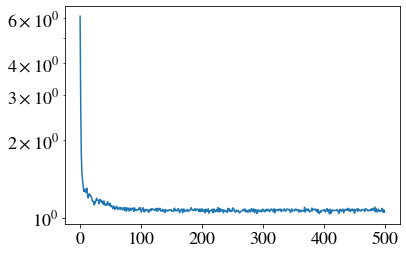

In [33]:
plt.plot(losses)
plt.yscale("log")